In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lmfit
import pandas as pd

plt.rcParams.update({'font.size': 18})

## Get Data

In [2]:
wd_wl, wd_fl = np.loadtxt('test_data/wd_spec.txt')
mpms_wl, mpms_fl = np.loadtxt('test_data/mpms_spec.txt')

wd_ugriz = np.loadtxt('test_data/wd_phot.txt')
mpms_ugriz = np.loadtxt('test_data/mpms_phot.txt')

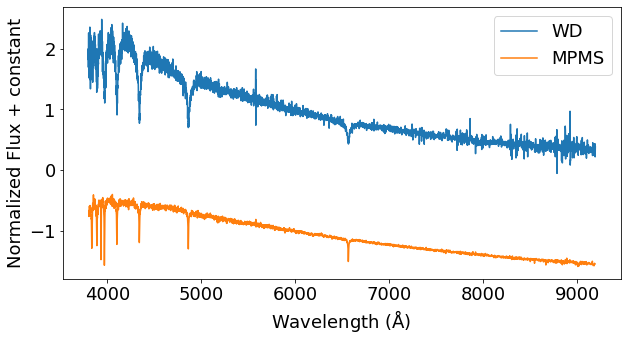

In [3]:
plt.figure(figsize = (10, 5))

plt.plot(wd_wl, wd_fl / np.median(wd_fl), label = 'WD')
plt.plot(mpms_wl, mpms_fl / np.median(mpms_fl) - 2, label = 'MPMS')

plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Normalized Flux + constant')

plt.legend();

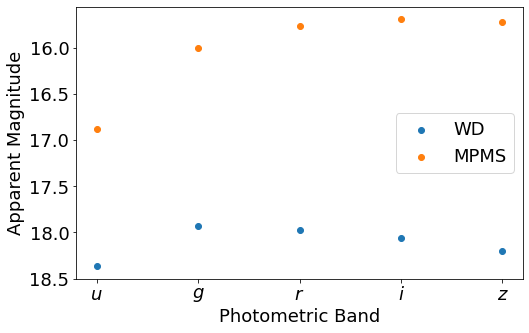

In [4]:
plt.figure(figsize = (8, 5))

bands = ['$u$', '$g$', '$r$', '$i$', '$z$']
colors = ['$u-g$', '$g-r$', '$r-i$', '$i-z$']

plt.scatter(bands, wd_ugriz, label = 'WD')
plt.scatter(bands, mpms_ugriz, label = 'MPMS')

plt.xlabel('Photometric Band')
plt.ylabel('Apparent Magnitude')

plt.gca().invert_yaxis()
plt.legend();

In [5]:
wd_colors = np.diff(wd_ugriz)
mpms_colors = np.diff(mpms_ugriz)

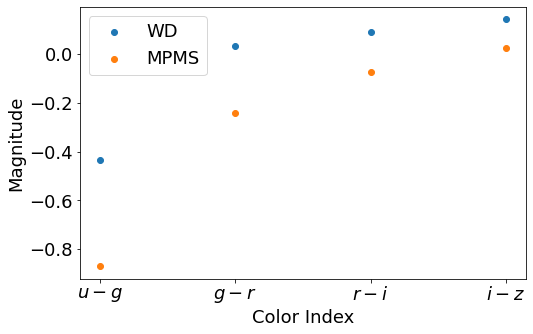

In [6]:
plt.figure(figsize = (8, 5))

plt.scatter(colors, wd_colors, label = 'WD')
plt.scatter(colors, mpms_colors, label = 'MPMS')
plt.xlabel('Color Index')
plt.ylabel('Magnitude')
plt.legend()

## Get Balmer Line Summaries

In [7]:
from classify_mpms import LineProfiles

lp = LineProfiles()

In [8]:
spec_features = ['a_fwhm', 'a_height',
       'b_fwhm', 'b_height',
       'g_fwhm', 'g_height',
         'd_fwhm', 'd_height']

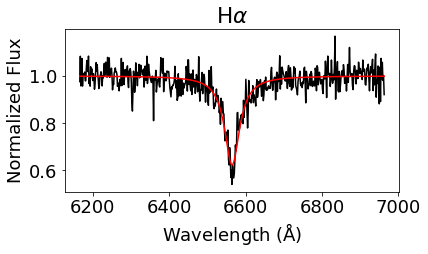

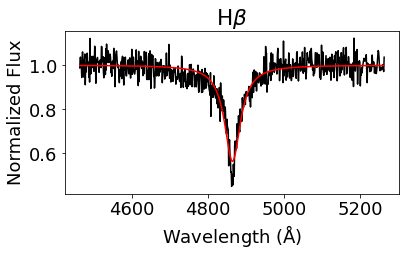

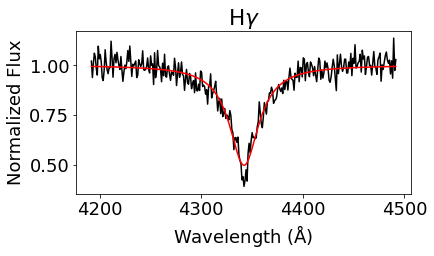

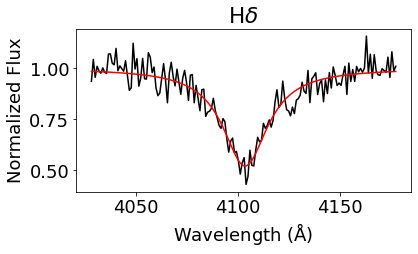

In [9]:
wd_balmer = lp.fit_balmer(wd_wl, wd_fl, make_plot = True)[spec_features]

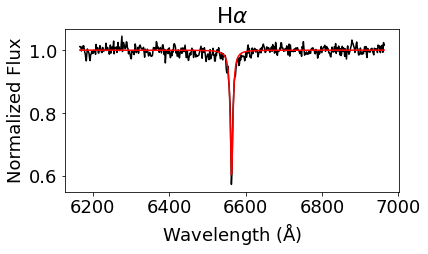

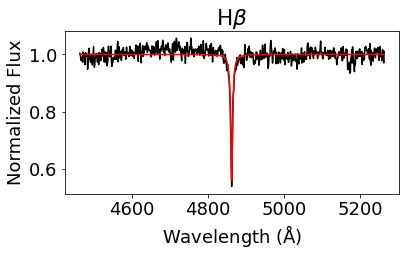

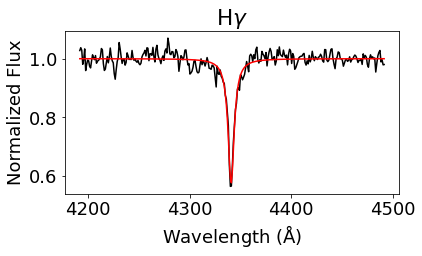

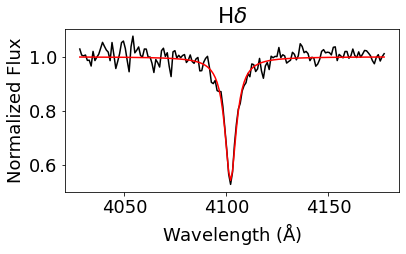

In [10]:
mpms_balmer = lp.fit_balmer(mpms_wl, mpms_fl, make_plot = True)[spec_features]

In [11]:
wd_balmer

,a_fwhm,a_height,b_fwhm,b_height,g_fwhm,g_height,d_fwhm,d_height
0,47.844292,0.377217,51.035479,0.436999,35.117631,0.501955,26.837174,0.480053


In [29]:
wd_features = np.hstack((wd_colors, np.array(wd_balmer)[0])).reshape(1, -1)
mpms_features = np.hstack((mpms_colors, np.array(mpms_balmer)[0])).reshape(1, -1)

In [30]:
data = np.vstack((wd_features, mpms_features))

## Classify

In [32]:
from classify_mpms import LRClassifier

In [33]:
features = ['ug', 'gr', 'ri', 'iz']
features.extend(spec_features)

In [34]:
print(features)

['ug', 'gr', 'ri', 'iz', 'a_fwhm', 'a_height', 'b_fwhm', 'b_height', 'g_fwhm', 'g_height', 'd_fwhm', 'd_height']


In [45]:
lrc = LRClassifier(features = features, training_grid = 'training_grid.csv')

In [50]:
p_mpms = lrc.classify(data)

print('Star 1 P(MPMS) = %.2f' % p_mpms[0])
print('Star 2 P(MPMS) = %.2f' % p_mpms[1])

Star 1 P(MPMS) = 0.00
Star 2 P(MPMS) = 0.92


#### Data-Driven Training Grid

In [47]:
lrc_dd = LRClassifier(features = features, training_grid = 'dd_grid.csv')

In [49]:
p_mpms_dd = lrc_dd.classify(data)

print('Star 1 P(MPMS) = %.2f' % p_mpms_dd[0])
print('Star 2 P(MPMS) = %.2f' % p_mpms_dd[1])

Star 1 P(MPMS) = 0.00
Star 2 P(MPMS) = 0.96
